In [22]:
import sionna.rt as rt
import numpy as np
import matplotlib.pyplot as plt

## 2.3 直接波と平面大地反射による2波モデル

平面大地反射による2波モデルでは、受信信号振幅$r$は以下のように表すことができる。

$
r \\
= |E_d (1+\alpha \exp(-j \Delta \phi))| \\
= 2|E_d sin(\frac{\Delta \phi}{2})|
$

$\Delta \phi \sim \frac{4 \pi h_r h_t}{\lambda d}$

定性的に考えると、$d$がある程度以下の場合は、距離に応じた様々な位相差で反射波がたどり着くので、受信電力は大きくなったり小さくなったりする。
しかし、$d$が大きくなると、直接波と反射波の距離がほとんど同じになるため、位相差はほぼ$\pi$となって受信電力が揺れることはなくなる。
さらに、$\sin(\theta)\sim \theta$が成り立つことにより、$P_r/P_t \propto 1/d^4$となる。
この地点をブレークポイントと呼ぶ。

In [23]:
xs = np.logspace(1, 6, 1000, endpoint=True)
display_radius = np.diff(xs).min() / 10
scene = rt.load_scene(rt.scene.simple_reflector, merge_shapes=False)

tx = rt.Transmitter(name="tx", position=[0, 0, 10], display_radius=display_radius)
scene.add(tx)

for x in xs:
    rx = rt.Receiver(
        name=f"rx{x:.2f}".replace(".", ""), position=[float(x), 0, 1.5],
        display_radius=0.1
    )
    scene.add(rx)

scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# default size is 1x1x0
scene.objects["reflector"].scaling = xs.max()*2

p_solver = rt.PathSolver()
paths = p_solver(
    scene=scene,
    los=True,
)

fig = scene.preview(paths=paths, fov=135, resolution=(1000, 1000))

どうも、受信機が多い時はうまくレンダリングされない模様。

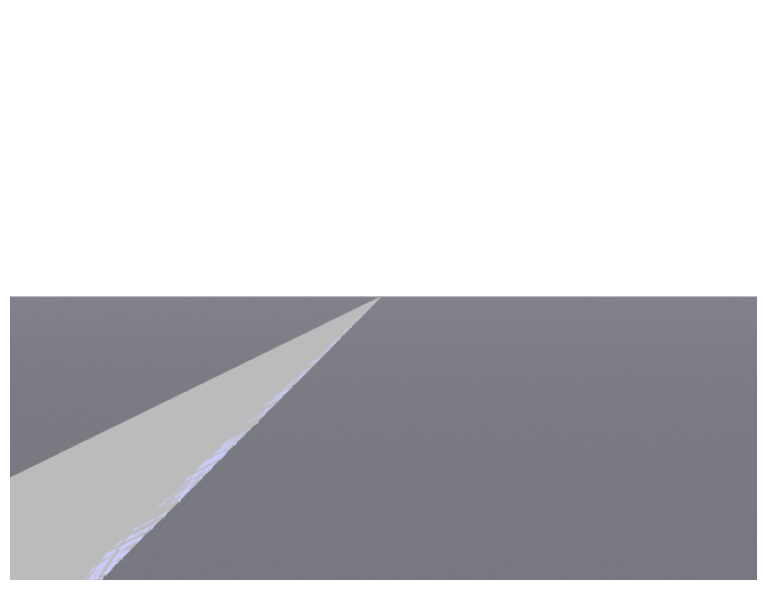

In [24]:
fig = scene.render(
    camera=rt.Camera(position=[0,-20,20]),
    paths=paths,
    num_samples = 512,
)

In [25]:
h_freq = paths.cfr(frequencies=[2e9],
                   normalize=False, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

ある距離までは2乗に比例して電力が振動しながら減衰し、その後4乗で減衰していくのがわかる。

/tmp/ipykernel_25277/4206099641.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


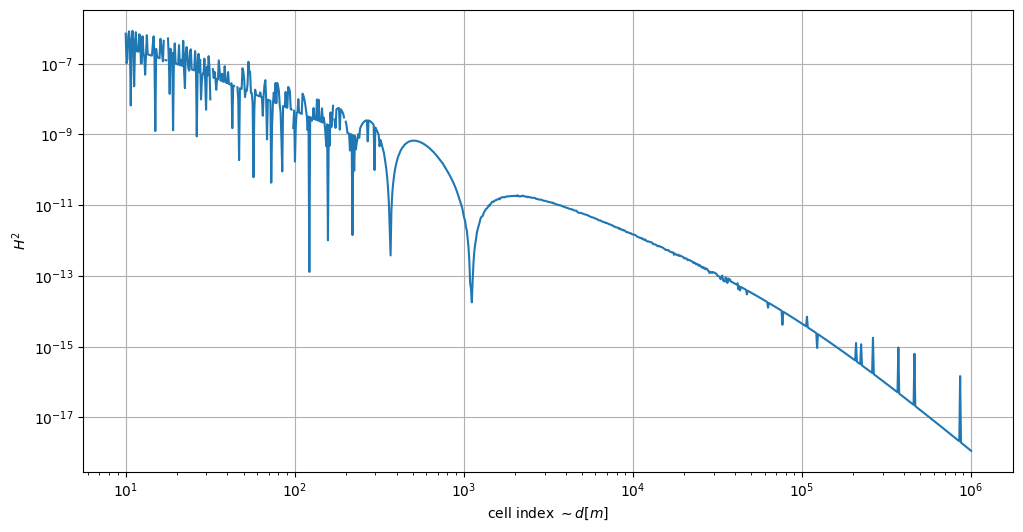

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(xs, np.abs(h_freq.flatten())**2)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel(r"$H^2$")
ax.set_xlabel(r"cell index $\sim d [m]$")
ax.grid()
fig.show()